<h1>Подбор пар для осеменения коров

<b>Разработать алгоритм, который:</b>
1. Максимизирует среднюю ожидаемую селекционную ценность потомства (EBV).
2. Обеспечивает максимально возможный разброс EBV среди потомков (для сохранения генетического разнообразия и будущего селекционного потенциала).
3. Соблюдает ограничения по родству и использованию быков.

<b>Входные данные:</b>

1. pedigree.csv – родословные животных:
    - id: идентификатор животного
    - mother_id: идентификатор матери
    - father_id: идентификатор отца
2. bulls.csv – быки-кандидаты на осеменение:
    - id: идентификатор быка
    - ebv: селекционная ценность (Estimated Breeding Value)
3. cows.csv – коровы, которых нужно осеменить:
    - id: идентификатор коровы
    - ebv: селекционная ценность

Критерии и ограничения, которые нужно учитывать:
1. Ожидаемый EBV потомка
    - Рассчитывается как среднее значение между EBV быка и коровы.
    - Необходимо максимизировать среднее значение по всему закреплению.
2. Разнообразие потомства
    - При прочих равных предпочтение даётся таким парам, где разброс EBV потомков больше.
3. Генетическое разнообразие
    - Уровень родства в паре не должен превышать 5%.
4. Ограничение по использованию быков
    - Один бык не может осеменить более 10% коров.

<b>Выход:</b>

Файл cow_bull_assignments.csv со следующими колонками:
1. cow_id: идентификатор коровы
2. bull_id: идентификатор подобранного быка
Каждая корова из таблицы должна быть закреплена за быком.

Описание логики
- Какую стратегию вы использовали?
- Какие ограничения реализованы?
- Какими допущениями/упрощениями вы руководствовались?
- Какими метриками результата закрепления вы пользовались чтобы выбрать лучший из подходов?

In [9]:
!pip install seaborn

<h2>IMPORTS

In [11]:
import sklearn

print("scikit-learn version:", sklearn.__version__)

scikit-learn version: 1.2.2


In [12]:
# ------------------- Imports -------------------
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import Counter
# ------------------- Constants -------------------
RANDOM_STATE = 170723
# ------------------- Visuals ---------------------

<h2>EDA

In [17]:
try:
    pedigree = pd.read_csv('pedigree.csv')
    bulls = pd.read_csv('bulls.csv')
    cows = pd.read_csv('cows.csv')
    
    print('using a local files')
    
except:
    ('loader is dead')

using a local files


<h2>Анализ родословной


=== Pedigree Analysis ===

Первые 5 записей:


,id,mother_id,father_id
0,GB00000090350,GB00000070596,FR00000051087
1,DE00000090351,GB00000085021,GB00000051158
2,US00000090352,US00000087323,GB00000091078
3,FR00000090353,NaN,NaN
4,GB00000090358,US00000056066,NL00000050889



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94400 entries, 0 to 94399
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         94400 non-null  object
 1   mother_id  87822 non-null  object
 2   father_id  89562 non-null  object
dtypes: object(3)
memory usage: 2.2+ MB
None

Описательная статистика:


,id,mother_id,father_id
count,94400,87822,89562
unique,94400,45703,2687
top,GB00000090350,RU00000046768,FR00000002912
freq,1,206,2306



Пропущенные значения:


id              0
mother_id    6578
father_id    4838
dtype: int64


Расчет глубины родословной...


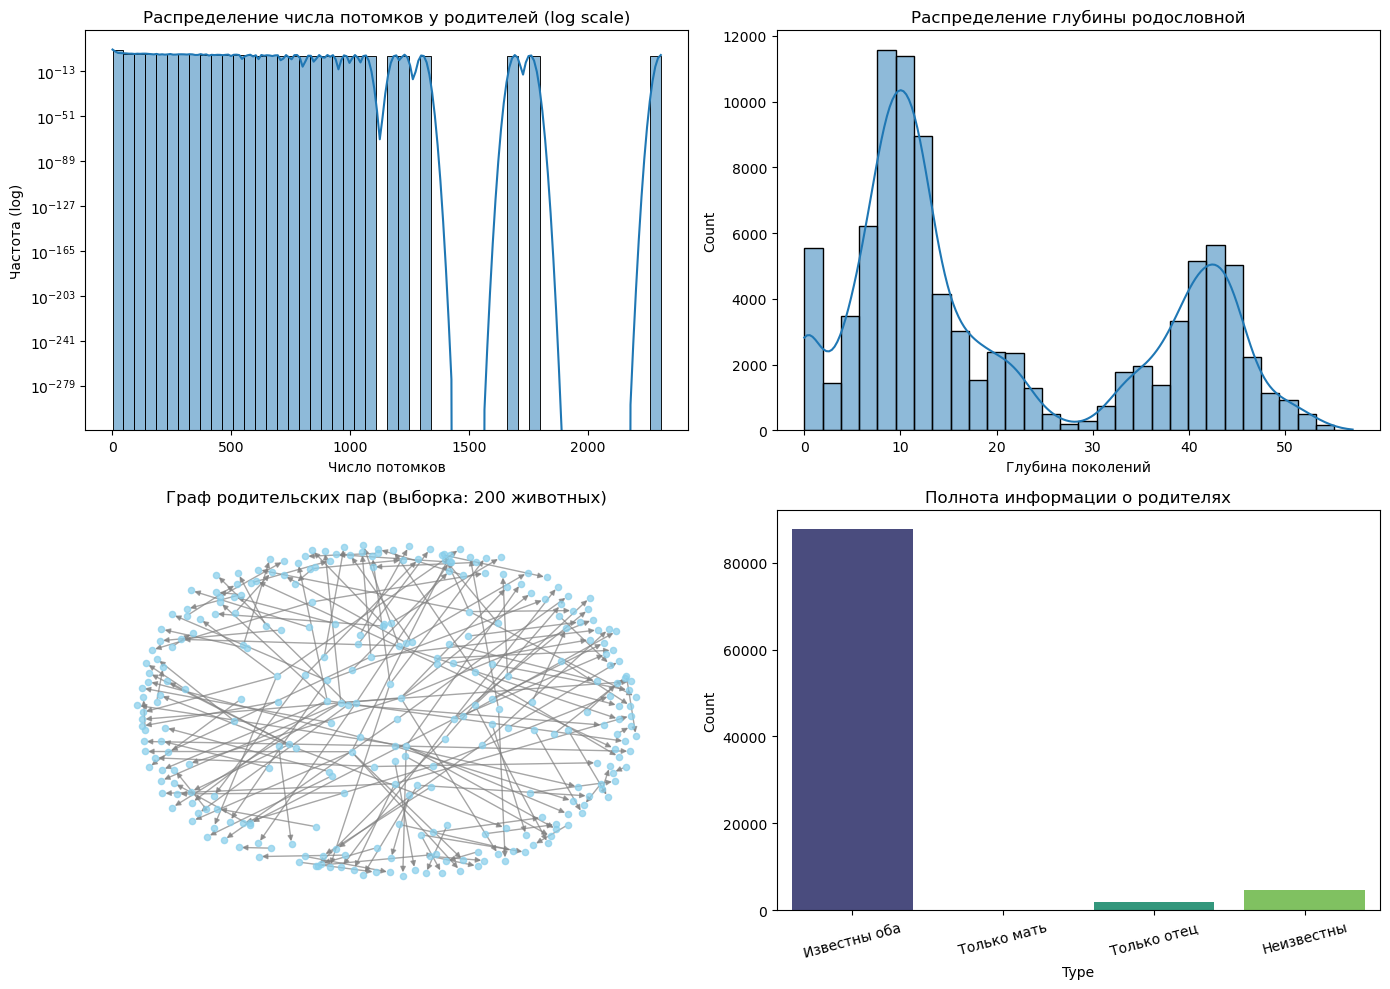

In [21]:
# Ячейка 3: Анализ родословной (исправленная версия)
print("\n=== Pedigree Analysis ===")
print("\nПервые 5 записей:")
display(pedigree.head())

print("\nИнформация о данных:")
print(pedigree.info())

print("\nОписательная статистика:")
display(pedigree.describe(include='all'))

# Проверка пропусков
print("\nПропущенные значения:")
display(pedigree.isnull().sum())

# Предварительная обработка данных
# Удаление дубликатов и замена NaN на None
pedigree_clean = pedigree.copy()
pedigree_clean = pedigree_clean.drop_duplicates('id')
pedigree_clean = pedigree_clean.replace({np.nan: None})

# Оптимизированный расчет глубины родословной с помощью BFS
print("\nРасчет глубины родословной...")
from collections import deque

# Подготовка структур данных
nodes = pedigree_clean['id'].tolist()
graph = {node: [] for node in nodes}  # Список детей для каждого родителя
in_degree = {node: 0 for node in nodes}  # Количество известных родителей
depth = {node: 0 for node in nodes}  # Глубина для каждого узла

# Построение графа и подсчет входящих связей
for _, row in pedigree_clean.iterrows():
    child = row['id']
    mother = row['mother_id']
    father = row['father_id']
    
    # Обработка связей "родитель->ребенок"
    for parent in [mother, father]:
        if parent is not None:
            # Если родитель есть в нашем списке узлов
            if parent in graph:
                graph[parent].append(child)
                in_degree[child] += 1
            # Если родителя нет в списке - добавляем его
            else:
                graph[parent] = [child]
                in_degree[parent] = 0
                in_degree[child] = in_degree.get(child, 0) + 1
                depth[parent] = 0

# Находим корневые узлы (животных без известных родителей)
roots = [node for node in graph.keys() if in_degree[node] == 0]

# Обход в ширину (BFS)
queue = deque(roots)
while queue:
    node = queue.popleft()
    if node in graph:  # Проверка существования узла в графе
        for child in graph[node]:
            if child in depth:  # Проверка существования ребенка в словаре глубины
                # Обновляем глубину ребенка
                depth[child] = max(depth[child], depth[node] + 1)
                in_degree[child] -= 1
                # Если все родители обработаны - добавляем в очередь
                if in_degree[child] == 0:
                    queue.append(child)

# Получаем глубины только для животных из родословной
depths = [depth.get(id, 0) for id in pedigree_clean['id']]

# Визуализация структуры родословной
plt.figure(figsize=(14, 10))

# 1. Распределение числа потомков у родителей
plt.subplot(2, 2, 1)
ped_counts = pedigree_clean[['mother_id', 'father_id']].stack().value_counts()
sns.histplot(ped_counts, bins=50, kde=True, log_scale=(False, True))
plt.title('Распределение числа потомков у родителей (log scale)')
plt.xlabel('Число потомков')
plt.ylabel('Частота (log)')

# 2. Глубина родословной (оптимизированный расчет)
plt.subplot(2, 2, 2)
sns.histplot(depths, bins=30, kde=True)
plt.title('Распределение глубины родословной')
plt.xlabel('Глубина поколений')

# 3. Граф связей (исправленная визуализация)
plt.subplot(2, 2, 3)
sample_size = min(200, len(pedigree_clean))  # Уменьшенный размер выборки
sample_ped = pedigree_clean.sample(sample_size, replace=False)

# Создаем граф только для существующих связей
edges = []
for _, row in sample_ped.iterrows():
    if row['father_id'] is not None and row['mother_id'] is not None:
        # Добавляем связь между родителями
        edges.append((row['father_id'], row['mother_id']))

if len(edges) > 0:
    G = nx.DiGraph()
    G.add_edges_from(edges)
    
    # Упрощаем граф для визуализации
    if len(G) > 0:
        # Уменьшаем k для более компактного размещения
        pos = nx.spring_layout(G, k=0.3, iterations=50)
        
        # Рисуем граф с ПРАВИЛЬНЫМ параметром arrowsize
        nx.draw(
            G, pos, 
            with_labels=False, 
            node_size=20, 
            arrowsize=8,  # Исправлено здесь: arrow_size → arrowsize
            node_color='skyblue',
            edge_color='gray',
            alpha=0.7
        )
        plt.title(f'Граф родительских пар (выборка: {sample_size} животных)')
    else:
        plt.text(0.5, 0.5, 'Нет связей для визуализации', 
                 ha='center', va='center')
        plt.title('Граф родительских пар')
else:
    plt.text(0.5, 0.5, 'Нет данных для визуализации', 
             ha='center', va='center')
    plt.title('Граф родительских пар')

# 4. Типы родителей
plt.subplot(2, 2, 4)
parent_types = pd.DataFrame({
    'Type': ['Известны оба', 'Только мать', 'Только отец', 'Неизвестны'],
    'Count': [
        pedigree_clean[(pedigree_clean['mother_id'].notnull()) & (pedigree_clean['father_id'].notnull())].shape[0],
        pedigree_clean[(pedigree_clean['mother_id'].notnull()) & (pedigree_clean['father_id'].isnull())].shape[0],
        pedigree_clean[(pedigree_clean['mother_id'].isnull()) & (pedigree_clean['father_id'].notnull())].shape[0],
        pedigree_clean[(pedigree_clean['mother_id'].isnull()) & (pedigree_clean['father_id'].isnull())].shape[0]
    ]
})
sns.barplot(x='Type', y='Count', data=parent_types, palette='viridis')
plt.title('Полнота информации о родителях')
plt.xticks(rotation=15)
plt.tight_layout()

plt.tight_layout()
plt.show()